In [2]:
import os
from umap import UMAP
import glob
import torch
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
import umap
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
folder_path = "vectorized_torch_seq"

In [5]:
word_embeddings = []

for filename in os.listdir(folder_path):
    if filename.endswith('.pt'):
        embeddings = torch.load(os.path.join(folder_path, filename))
        word_embeddings.append(embeddings)

word_embeddings = torch.cat(word_embeddings, dim=0)

In [6]:
word_embeddings.shape

torch.Size([2844, 768])

In [7]:
embeddings_list = word_embeddings.detach().numpy()

In [8]:
embeddings_list[:10]

array([[-0.13901965, -0.03041915,  0.36099693, ...,  0.01197663,
         0.01414834,  0.45038122],
       [-0.3896122 , -0.01801682,  0.2704455 , ...,  0.0071761 ,
        -0.66425717,  0.25446358],
       [-0.13901965, -0.03041915,  0.36099693, ...,  0.01197663,
         0.01414834,  0.45038122],
       ...,
       [-0.3896122 , -0.01801682,  0.2704455 , ...,  0.0071761 ,
        -0.66425717,  0.25446358],
       [-0.13901965, -0.03041915,  0.36099693, ...,  0.01197663,
         0.01414834,  0.45038122],
       [-0.3896122 , -0.01801682,  0.2704455 , ...,  0.0071761 ,
        -0.66425717,  0.25446358]], dtype=float32)

In [9]:
embeddings_list.shape

(2844, 768)

In [14]:
#UMAP dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.000001, n_components=2, metric = "cosine").fit_transform(embeddings_list)

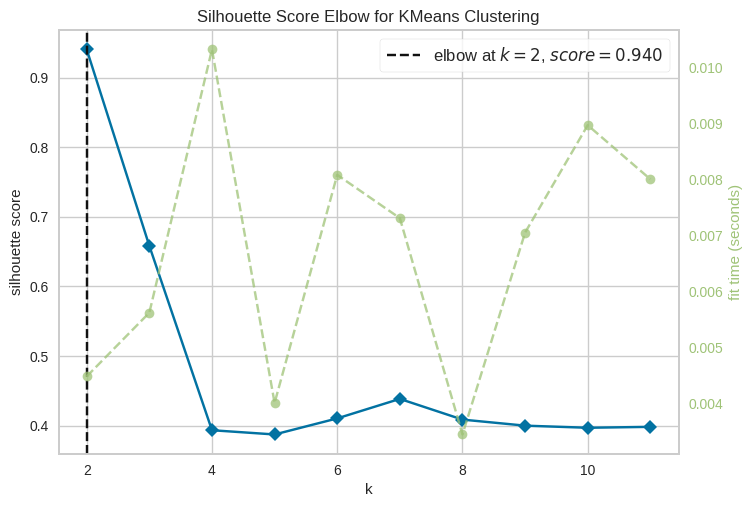

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [15]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11,metric='silhouette', timings= True)
visualizer.fit(umap_embeddings)
visualizer.show()

### DBSCAN

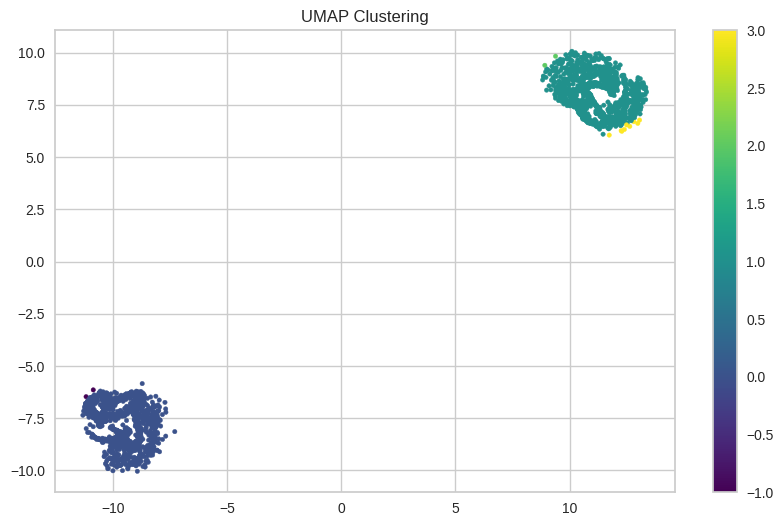

In [16]:
# DBSCAN stuff
dbscan = DBSCAN(eps=0.00001, min_samples=2, metric="cosine")
clustersdbscan = dbscan.fit_predict(umap_embeddings)
# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clustersdbscan, cmap='viridis', s=10)
plt.title('UMAP Clustering')
plt.colorbar()
plt.show()

### Agglomerative Clustering

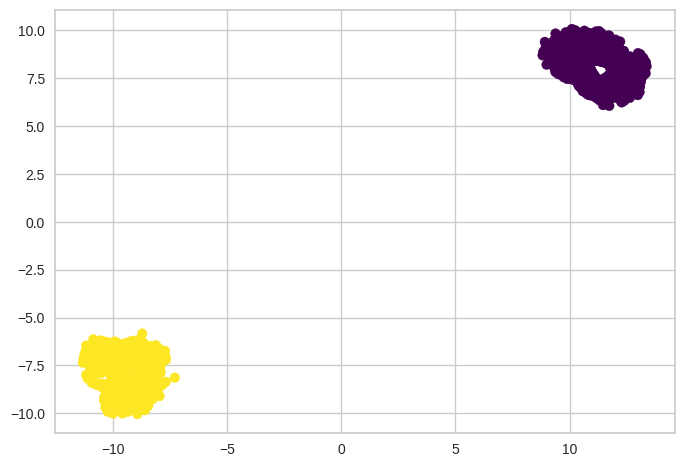

In [17]:
c = AgglomerativeClustering(n_clusters=2).fit(umap_embeddings)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=c.labels_, cmap='viridis');

In [18]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [19]:
X_train, X_test, y_train, y_test = train_test_split(umap_embeddings, c.labels_, test_size=0.3, random_state=42)

In [20]:
X_train

array([[-9.01245278, -7.88572653],
       [-8.34974786, -7.78410193],
       [10.59412878,  6.89593031],
       ...,
       [-9.97670017, -8.00195909],
       [-9.66317193, -7.12597161],
       [-9.17026212, -8.87130469]])

In [21]:
y_train

array([1, 1, 0, ..., 1, 1, 1])

In [22]:
catboost_model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.01)
catboost_model.fit(X_train, y_train)

0:	learn: 0.6836921	total: 47ms	remaining: 4.65s
1:	learn: 0.6743310	total: 47.9ms	remaining: 2.35s
2:	learn: 0.6651166	total: 48.5ms	remaining: 1.57s
3:	learn: 0.6562104	total: 49ms	remaining: 1.18s
4:	learn: 0.6474452	total: 49.5ms	remaining: 941ms
5:	learn: 0.6387365	total: 49.9ms	remaining: 782ms
6:	learn: 0.6301699	total: 50.4ms	remaining: 670ms
7:	learn: 0.6217712	total: 50.8ms	remaining: 584ms
8:	learn: 0.6135612	total: 51.3ms	remaining: 519ms
9:	learn: 0.6055074	total: 51.8ms	remaining: 466ms
10:	learn: 0.5977276	total: 52.2ms	remaining: 422ms
11:	learn: 0.5899966	total: 52.8ms	remaining: 388ms
12:	learn: 0.5823123	total: 53.4ms	remaining: 357ms
13:	learn: 0.5747735	total: 53.8ms	remaining: 331ms
14:	learn: 0.5673904	total: 54.3ms	remaining: 307ms
15:	learn: 0.5601375	total: 54.7ms	remaining: 287ms
16:	learn: 0.5530720	total: 55.2ms	remaining: 270ms
17:	learn: 0.5459032	total: 55.5ms	remaining: 253ms
18:	learn: 0.5389992	total: 56ms	remaining: 239ms
19:	learn: 0.5321592	total: 

In [23]:
y_pred = catboost_model.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       421
           1       1.00      1.00      1.00       433

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



In [64]:
catboost_model.save_model('bi_model.catboost')